<a href="https://colab.research.google.com/github/sayarghoshroy/Hate-Speech-Detection/blob/master/HASOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install Libraries

In [9]:
!pip install nltk
!pip install bert-tensorflow
!pip install transformers
!pip install seaborn
!pip install sklearn-crfsuite
!pip install -U sentence-transformers
import nltk
nltk.download('punkt')
nltk.download('stopwords')

Requirement already up-to-date: sentence-transformers in /usr/local/lib/python3.6/dist-packages (0.3.6)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Get imports

- **General:** random, pickle, re, time, datetime
- **General DS:** pandas, numpy, sklearn, matplotlib, seaborn, nltk
- **Deep Learning:** torch, transformers

In [40]:
import random
import pickle
import re
import time
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, neighbors
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

import torch
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from sentence_transformers import SentenceTransformer

# GPU device Setup

In [11]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Dataset loading

In [12]:
DATASET_ROOT = '/content/drive/My Drive/2020_processed_data/'

In [13]:
with open(DATASET_ROOT+'hi.pickle', 'rb') as f:
  ged = pickle.load(f)

Checking it once for content description

In [14]:
ged.keys()

dict_keys(['tweet_id', 'task_1', 'task_2', 'hasoc_id', 'full_tweet', 'tweet_raw_text', 'hashtags', 'smiley', 'emoji', 'url', 'mentions', 'numerals', 'reserved_word', 'emotext', 'segmented_hash'])

In [52]:
ged['task_1'][:10]

['HOF', 'NOT', 'HOF', 'HOF', 'HOF', 'HOF', 'HOF', 'HOF', 'NOT', 'NOT']

## Split data into train-test-val

In [16]:
# train1_hash = ged['segmented_hash'][:2000]
# test1_hash = ged['segmented_hash'][2000:]

In [17]:
# train_hash = []
# for lis in train1_hash:
#   train_hash.append(' '.join(lis))
# test_hash = []
# for lis in test1_hash:
#   test_hash.append(' '.join(lis))

In [18]:
# train_text, test_text, train_t1s, test_t1s = model_selection.train_test_split(
#     ged['tweet_raw_text'],
#     ged['task_1'],
#     test_size = 0.2,
#     # random_state = 42
# )

In [19]:
# train_text = ged['tweet_raw_text'][:2000]
# train_t1s = ged['task_1'][:2000]

# test_text = ged['tweet_raw_text'][2000:]
# test_t1s = ged['task_1'][2000:]

In [20]:
df = pd.DataFrame.from_dict(ged)
# df = df.sample(frac=1).reset_index(drop=True)

In [21]:
train_df, test_df = model_selection.train_test_split(df, random_state = 42, test_size = 0.25)

In [22]:
train1_hash = list(train_df['segmented_hash'])
test1_hash = list(test_df['segmented_hash'])
train_hash = []
for lis in train1_hash:
  train_hash.append(' '.join(lis))
test_hash = []
for lis in test1_hash:
  test_hash.append(' '.join(lis))
train_text = list(train_df['tweet_raw_text'])
train_t1s = list(train_df['task_1'])

test_text = list(test_df['tweet_raw_text'])
test_t1s = list(test_df['task_1'])

# get Functions

In [23]:
def get_features(embeddings):
  # emb = []
  # for e in embeddings:
  #   emb.append({'feat': e})
  emb = embeddings
  return emb

In [54]:
def get_task(tasklist, taskType = 1):
  newtasks = []
  if taskType == 2:
    for x in tasklist:
      if x == "NONE":
        newtasks.append(0)
      elif x == "HATE":
        newtasks.append(1)
      elif x == "PRFN":
        newtasks.append(2)
      elif x == "OFFN":
        newtasks.append(3)
      else:
        raise NameError("Class not defined")
  else:
    for x in tasklist:
      if x == 'NOT':
        # newtasks.append(['0'])
        newtasks.append(0)
      elif x =="HOF":
        # newtasks.append(['1'])
        newtasks.append(1)
      else:
        raise NameError("Class not defined")

  return newtasks

In [27]:
import gensim.models as gsm
e2v = gsm.KeyedVectors.load_word2vec_format('emoji2vec.bin', binary=True)
# happy_vector = e2v['😂']    # Produces an embedding vector of length 300

# Download the bin file from here https://github.com/uclnlp/emoji2vec/blob/master/pre-trained/emoji2vec.bin

def getEmojiEmbeddings(emojiList,dim=300,verbose = False):
  """ Generates an emoji vector by averaging the emoji representation for each emoji. If no emoji returns an empty list of dimension dim"""
  if dim < 300:
    raise IndexError("Dim has to be greater than 300")
  result = np.zeros(dim)
  if (len(emojiList) == 0):
    return result
  else:
    embs = None
    for i in emojiList:
      if verbose:
        if i not in e2v.vocab:
          print(i)
    embs = np.mean([e2v[i] for i in emojiList if i in e2v.vocab], axis=0)
  if np.any(np.isnan(embs)):
    return result
  result[:300] = embs
  return result 


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# Ablation Studies

In [60]:
from transformers import AutoTokenizer, AutoModelWithLMHead

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/xlm-r-100langs-bert-base-nli-mean-tokens")
sent_encoder = SentenceTransformer('xlm-r-100langs-bert-base-nli-mean-tokens')

In [42]:

a = []
b = []
def trainModelWithFeatures(train_df,test_df, hashtags=True, emojis=True, verbose = False):
  """ Function to train a model on a specific configuration of features """
  global a
  global b
  train1_hash = list(train_df['segmented_hash'])
  test1_hash = list(test_df['segmented_hash'])
  train_hash = []
  for lis in train1_hash:
    train_hash.append(' '.join(lis))
  test_hash = []
  for lis in test1_hash:
    test_hash.append(' '.join(lis))
  train_text = list(train_df['tweet_raw_text'])
  train_t1s = list(train_df['task_1'])
  train_t2s =  list(train_df['task_2'])

  test_text = list(test_df['tweet_raw_text'])
  test_t1s = list(test_df['task_1'])
  test_t2s = list(test_df['task_2'])

  if verbose:
    print("Started getting text embeddings")
  train_embeddings = sent_encoder.encode(train_text)
  test_embeddings = sent_encoder.encode(test_text)
  if verbose:
    print("Finished loading up the text embeddings")
  train_t1 = get_task(train_t1s)
  train_t2 = get_task(train_t2s, 2)
  
  test_t1 = get_task(test_t1s)
  test_t2 = get_task(test_t2s,2)

  train_emb = get_features(train_embeddings)
  test_emb = get_features(test_embeddings)
  if hashtags:
    if verbose:
      print("Started getting hash embeddings")
    train_hashembeddings = sent_encoder.encode(train_hash)
    test_hashembeddings = sent_encoder.encode(test_hash)
    train_emb = np.concatenate((train_emb , train_hashembeddings), axis = 1)
    test_emb =  np.concatenate((test_emb , test_hashembeddings), axis = 1)

    if verbose:
      print("Finished loading up the hash embeddings")
  if emojis:
    if verbose:
      print("Started getting emoji embeddings")
    train_emojiEmbs = np.asarray([getEmojiEmbeddings(i,verbose=verbose) for i in (list(train_df['emoji']))])
    test_emojiEmbs = np.asarray([getEmojiEmbeddings(i,verbose=verbose) for i in (list(test_df['emoji']))])
    train_emb = np.concatenate((train_emb , train_emojiEmbs), axis = 1)
    test_emb = np.concatenate((test_emb , test_emojiEmbs), axis = 1)
    if verbose:
      print("Finished loading up the emoji embeddings")
  a = train_emb
  b = test_emb
  assert (train_t2 != test_t2)
  clf1 = MLPClassifier(random_state=1, max_iter=300).fit(train_emb, train_t1)
  clf2 =  MLPClassifier(random_state=1, max_iter=300).fit(train_emb, train_t2)
  if verbose:
    print("Finsihed training classifier")
  pred_test_t1 = clf1.predict(test_emb)
  pred_test_t2 = clf2.predict(test_emb)

  print("Task 1")
  print(classification_report(test_t1, pred_test_t1))
  print("Task 2")
  print(classification_report(test_t2, pred_test_t2))

  return clf1,clf2








In [67]:
def loadData(lang):
  """ Function to load data for one language from the preprocessed pickle file"""
  if lang not in ['hi','en','ge']:
      raise NameError("Language not found")
  fileName = lang + '.pickle'
  with open(DATASET_ROOT+fileName, 'rb') as f:
    ged = pickle.load(f)
  df = pd.DataFrame.from_dict(ged)
  train_df, test_df = model_selection.train_test_split(df, random_state = 42, test_size = 0.25)
  return train_df, test_df, df

def loadDataAllLangs():
  """ Function to load data for all languages from the preprocessed pickle file"""

  hi_train,hi_test,hi_df = loadData('hi')
  en_train,en_test,en_df = loadData('en')
  ge_train,ge_test,ge_df = loadData('ge')
  train_df = pd.concat([hi_train,en_train,ge_train],ignore_index=True)
  test_df =  pd.concat([hi_test,en_test,ge_test],ignore_index=True)
  df = pd.concat([hi_df,en_df,ge_df],ignore_index=True)
  train_df = train_df.sample(frac = 1, random_state=42)
  test_df = test_df.sample(frac = 1, random_state=42)
  df = df.sample(frac = 1, random_state=42)
  return train_df,test_df,df


  



In [71]:
train_df, test_df, df = loadDataAllLangs()

In [72]:
clf1,clf2 = trainModelWithFeatures(train_df,test_df,  verbose = False)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Task 1
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1386
           1       0.73      0.64      0.68       876

    accuracy                           0.77      2262
   macro avg       0.76      0.75      0.75      2262
weighted avg       0.77      0.77      0.77      2262

Task 2
              precision    recall  f1-score   support

           0       0.79      0.82      0.81      1386
           1       0.25      0.25      0.25       130
           2       0.62      0.65      0.63       508
           3       0.34      0.23      0.27       238

    accuracy                           0.69      2262
   macro avg       0.50      0.49      0.49      2262
weighted avg       0.68      0.69      0.68      2262



In [ ]:
def performAblations(train_df, test_df,features = ["hashtags", "emojis"], verbose = False):
  """ Perform Ablation studies on the given set of features """
  for i in features:
    if i not in ["hashtags", "emojis"]:
      raise NameError("Wrong set of features. ")
 # TODO Make it more extensible 
  results = {}
  print("all")
  results["hash+emoji"] = trainModelWithFeatures(train_df,test_df,  verbose = verbose)
  print("hash")
  results["hash"] = trainModelWithFeatures(train_df,test_df,emojis=False, verbose = verbose)
  print("emoji")
  results["emoji"] = trainModelWithFeatures(train_df,test_df,hashtags=False, verbose = verbose)
  print("vanilla")
  results["vanilla"] = trainModelWithFeatures(train_df,test_df,hashtags=False,emojis=False, verbose = verbose)
  return results

In [ ]:
r = performAblations(train_df, test_df,features = ["hashtags", "emojis"])

all


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.80      0.83      0.82       523
           1       0.56      0.51      0.53       218

    accuracy                           0.74       741
   macro avg       0.68      0.67      0.68       741
weighted avg       0.73      0.74      0.73       741

hash


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.80      0.82      0.81       523
           1       0.55      0.52      0.53       218

    accuracy                           0.73       741
   macro avg       0.68      0.67      0.67       741
weighted avg       0.73      0.73      0.73       741

emoji


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


              precision    recall  f1-score   support

           0       0.82      0.82      0.82       523
           1       0.56      0.56      0.56       218

    accuracy                           0.74       741
   macro avg       0.69      0.69      0.69       741
weighted avg       0.74      0.74      0.74       741

vanilla
              precision    recall  f1-score   support

           0       0.79      0.89      0.83       523
           1       0.61      0.42      0.50       218

    accuracy                           0.75       741
   macro avg       0.70      0.66      0.67       741
weighted avg       0.74      0.75      0.74       741



(300,)

# Pure BERT

## Loading Dataset

Loading the dataset into a dataframe, then transforming the labels

In [ ]:
DATASET_PATH = '/content/drive/My Drive/HASOC/Data/2020_train_sets/hasoc_2020_de_train.csv'

In [ ]:
df = pd.read_csv(DATASET_PATH)
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(10)

Number of training sentences: 2,452



,tweet_id,text,task1,task2,ID
2114,1124994968999858176,@dabiggapicta @twitpatli @operationlibero Stim...,NOT,NONE,hasoc_2020_de_1027
700,1133100503418703874,@iParaadox Das ist einfach anders,NOT,NONE,hasoc_2020_de_1592
1165,1131791712786030592,RT @DerZeroy: ich hab schon tweets gemacht da ...,HOF,OFFN,hasoc_2020_de_114
2416,1125436117518626822,@tagesschau Dankeschön❤️🌙😽,NOT,NONE,hasoc_2020_de_2238
1626,1134494044162277377,RT @ohnenahme: @MalteKaufmann @Nobby1949Z Ich ...,HOF,PRFN,hasoc_2020_de_1105
321,1134169870571098112,"RT @hl_h2o: Komm,mein Herz,geh und leg dich wi...",NOT,NONE,hasoc_2020_de_1212
1258,1125967141575057410,"So ist es, und war es schon immer. Die Menschh...",NOT,NONE,hasoc_2020_de_200
495,1124469888272216065,@bineuerboss @shoutoutxobella Würde Arsch geben,HOF,PRFN,hasoc_2020_de_996
507,1131202803140124672,in 🇱🇻 ballern jetzt einfach alle alle pointen ...,NOT,NONE,hasoc_2020_de_758
610,1128626259007660032,Daniel+Kermit &gt; Red+Andy,NOT,NONE,hasoc_2020_de_381


In [ ]:
LE = LabelEncoder()
df['task1'] = LE.fit_transform(df['task1'])
df['task2'] = LE.fit_transform(df['task2'])
df.head()

,tweet_id,text,task1,task2,ID
0,1133388798925189122,Deutsche rothaarige porno reife deutsche fraue...,1,1,hasoc_2020_de_2684
1,1131117000279961600,"Lehrstück auch, wie in der linken Jammerfemini...",0,1,hasoc_2020_de_2440
2,1127134592517980161,RT @NDRinfo: Die deutsche Klimaaktivistin Luis...,1,1,hasoc_2020_de_1042
3,1128897106171842560,@ruhrbahn jeden Morgen eine neue „Fahrzeugstör...,1,1,hasoc_2020_de_774
4,1123576753199484928,@Junge_Freiheit Die Inkas hatten sich schon dä...,1,1,hasoc_2020_de_559


In [ ]:
def count_words(text):
    return len(text.split())
df.text.apply(count_words).max()

31

In [ ]:
MAX_LENGTH = 74

## Splitting the Dataset

And then extracting the posts and tasks from that

In [ ]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(ged['tweet_raw_text'], get_task(ged['task_1']), test_size=0.2)
# train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df['text'], df['task1'], test_size=0.2, stratify=df['task1'])

In [ ]:
# posts = train_x.values
# categories = train_y.values
posts = train_x
categories = train_y

## Encoding the Data

Into BERT-type preprocessed things

In [ ]:
input_ids = []
attention_masks = []

# For every sentence...
for sent in posts:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                        truncation=True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(categories)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# print('Original: ', posts[0])
# print('Token IDs:', input_ids[0])

Original:  : Die hat die Bekleidung der Schler im linken Bild als Uniformierung gewertet. Die Bekleidung der Nazis rechts h
Token IDs: tensor([  102,   847,   125,   292,   125, 23474,   127,  2673, 30940,   197,
         5782,  1282,   250, 22326,   603, 26678,   552,   125, 23474,   127,
        22900,  1557,   134,   103,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [ ]:
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.875 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# print('{:>5,} training samples'.format(train_size))
# print('{:>5,} validation samples'.format(val_size))

1,660 training samples
  238 validation samples


In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-german-dbmdz-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 4, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-german-dbmdz-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [73]:
# params = list(model.named_parameters())

# print('The BERT model has {:} different named parameters.\n'.format(len(params)))

# print('==== Embedding Layer ====\n')

# for p in params[0:5]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# print('\n==== First Transformer ====\n')

# for p in params[5:21]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# print('\n==== Output Layer ====\n')

# for p in params[-4:]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


In [ ]:
optimizer = AdamW(model.parameters(),
                lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
            )

In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



In [ ]:
seed_val = 42
torch.cuda.empty_cache()
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    104.    Elapsed: 0:00:10.
  Batch    80  of    104.    Elapsed: 0:00:21.

  Average training loss: 0.53
  Training epoch took: 0:00:27

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.40
  Validation took: 0:00:01

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    104.    Elapsed: 0:00:10.
  Batch    80  of    104.    Elapsed: 0:00:20.

  Average training loss: 0.36
  Training epoch took: 0:00:26

Running Validation...
  Accuracy: 0.86
  Validation Loss: 0.41
  Validation took: 0:00:01

======== Epoch 3 / 3 ========
Training...
  Batch    40  of    104.    Elapsed: 0:00:10.
  Batch    80  of    104.    Elapsed: 0:00:20.

  Average training loss: 0.29
  Training epoch took: 0:00:26

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.43
  Validation took: 0:00:01

Training complete!
Total training took 0:01:23 (h:mm:ss)


In [76]:
# import pandas as pd

# pd.set_option('precision', 2)

# df_stats = pd.DataFrame(data=training_stats)

# df_stats = df_stats.set_index('epoch')

# df_stats

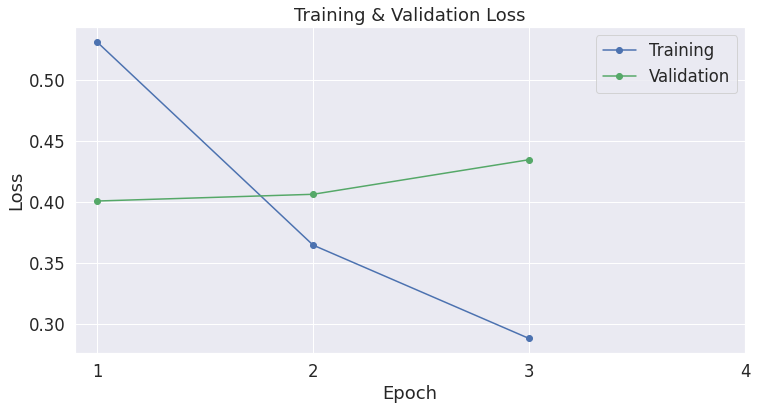

In [ ]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# posts = valid_x.values
# categories = valid_y.values
posts = valid_x
categories = valid_y

In [ ]:
input_ids = []
attention_masks = []

# For every sentence...
for sent in posts:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                        truncation = True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(categories)

# Set the batch size.  
batch_size = 16

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')


Predicting labels for 475 test sentences...
    DONE.


In [ ]:
print(predictions[0],true_labels[0])

[[ 2.815918    0.67652035 -2.2650628  -2.2906172 ]
 [ 3.8203065   0.5583332  -2.6725311  -2.4873564 ]
 [ 3.9499502   0.24259631 -2.4285192  -2.5219963 ]
 [ 3.8023715   0.8992263  -2.5455017  -2.6608763 ]
 [ 3.5275538   0.95858186 -2.3949318  -2.4766378 ]
 [ 3.887617    0.8140077  -2.6724727  -2.5248737 ]
 [ 0.16910587  3.6695373  -2.1501563  -1.9946499 ]
 [ 3.9468524   0.59644496 -2.5063562  -2.649984  ]
 [ 3.4229798   1.6607033  -2.573406   -2.9573843 ]
 [ 3.6360824   0.6973718  -2.5745804  -2.4552243 ]
 [ 3.3757284   1.1719614  -2.5285096  -2.8608246 ]
 [ 2.4881876   2.7517326  -2.7661166  -2.5374627 ]
 [ 3.873526    1.1388052  -2.6257365  -2.922611  ]
 [ 1.1770823   3.7499785  -2.6348324  -2.4921196 ]
 [ 3.671365    0.7367661  -2.4249887  -2.6031053 ]
 [ 3.5447338   1.9936495  -2.782876   -2.8870366 ]] [0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1]


In [74]:
# from sklearn.metrics import matthews_corrcoef

# matthews_set = []
# predicts = []
# accurate = 0
# total_len = 0
# # Evaluate each test batch using Matthew's correlation coefficient
# print('Calculating Matthews Corr. Coef. for each batch...')

# # For each input batch...
# for i in range(len(true_labels)):
#     # The predictions for this batch are a 2-column ndarray (one column for "0" 
#     # and one column for "1"). Pick the label with the highest value and turn this
#     # in to a list of 0s and 1s.
#     pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
#     predicts.append(pred_labels_i)
#     # Calculate and store the coef for this batch.  
#     matthews = matthews_corrcoef(true_labels[i], pred_labels_i)

#     matthews_set.append(matthews)
#     for j in range(len(true_labels[i])):
#         if true_labels[i][j] == pred_labels_i[j]:
#             accurate+=1
#         total_len+=1
# print("Accuracy:",accurate/total_len)

In [75]:
# ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

# plt.title('MCC Score per Batch')
# plt.ylabel('MCC Score (-1 to +1)')
# plt.xlabel('Batch #')

# plt.show()


In [ ]:
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.560


In [ ]:
accurate = 0
for (i,j) in zip(flat_predictions, flat_true_labels):
    if i==j:
        accurate += 1
accurate/len(flat_predictions)

0.8273684210526315

In [ ]:
from sklearn.metrics import f1_score
f1_score(flat_true_labels, flat_predictions, average='macro')

0.775094696969697